In [1]:
import numpy as np
import pandas as pd
import cv2
import json
import pickle
import os
import matplotlib
from matplotlib import pylab as plt
import sys
from scipy.spatial import distance_matrix

In [2]:
sys.path.append('/home/devel/workspaces/finest_mobility/src/data_unpack/src')

In [3]:
import lidar_camera_projection

In [4]:
def get_lidar_xyz(i):
    with open(f'/home/devel/finest_data/lidar_cam_calib_db_project/lidar/seq_{i}_lidar.pkl', 'rb') as _fd:
        return pickle.load(_fd)[:,:3]

In [5]:
def get_radar_xyz(i, radar='radar1'):
    with open(f'/home/devel/finest_data/lidar_cam_calib_db_project/{radar}/seq_{i}_{radar}.json', 'rb') as _fd:
        df_radar1 = pd.concat([pd.DataFrame(x, index=[i]) for i,x in enumerate(json.load(_fd))])
        return df_radar1[['x','y','z']].values

In [6]:
def get_cam_img(i):
    return cv2.imread(f'/home/devel/finest_data/lidar_cam_calib_db_project/camera/seq_{i}_rgb.png',
                      cv2.IMREAD_UNCHANGED)

In [7]:
def get_sync_frames(df_sync, lidar_seq, radar='radar1'):
    '''Index is lidar'''
    cam_seq, radar_seq = df_sync.loc[lidar_seq][['cam',radar]].values
    return (get_lidar_xyz(lidar_seq),
            get_cam_img(cam_seq),
            get_radar_xyz(radar_seq, radar))

In [8]:
def get_sync_frames_v2(df_sync, radar_seq, radar='radar1'):
    '''Index is radar'''
    cam_seq, lidar_seq = df_sync.loc[radar_seq][['cam','lidar']].values
    return (get_lidar_xyz(lidar_seq),
            get_cam_img(cam_seq),
            get_radar_xyz(radar_seq, radar))

In [9]:
def get_neaerest_lidar(lidar_xyz, radar_xyz, tresh_m):
    return lidar_xyz[np.unique(np.argwhere(distance_matrix(lidar_xyz, radar_xyz) < tresh_m)[:,0])]

In [10]:
def plot_lidar_radar(lidar_radar_xyz, radar_xyz, radar_xyz_tr, figure_out=None, lidar_xyz=None):
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(projection='3d')
    if lidar_xyz is not None:
        ax.scatter(*lidar_xyz.T, color='green', alpha=.005, label='lidar_all')
    ax.scatter(*lidar_radar_xyz.T, color='blue', label='lidar_radar')
    ax.scatter(*radar_xyz.T, color='yellow', label='radar1')
    ax.scatter(*radar_xyz_tr.T, color='red', label='radar1_tr')
    ax.legend(loc=0)
    if figure_out is not None:
        plt.savefig(figure_out)
    plt.show()

In [12]:
def get_lidar_cam_radar_sync(df_sync_radar1_lidar, df_lidar_cam_sync):
    '''Index is radar'''
    return  df_sync_radar1_lidar.set_index('radar1').join(df_lidar_cam_sync.set_index('lidar'), on='lidar')

In [34]:
def loop_step(i, df_lidar_cam_radar_sync, tr_radar_lidar, thresh_m=1.):
    lidar_xyz, img, radar_xyz = get_sync_frames_v2(df_lidar_cam_radar_sync, i, 'radar1')
    radar_xyz_tr = xyz_transform(radar_xyz, tr_radar_lidar)
    lidar_radar_xyz = get_neaerest_lidar(lidar_xyz, radar_xyz_tr, thresh_m)
    return lidar_xyz, radar_xyz, radar_xyz_tr, lidar_radar_xyz, img

In [14]:
def xyz_transform(np_xyz, np_mat_tr):
    assert np_mat_tr.shape == (3,4)
    assert np_xyz.shape[1] == 3
    return np.dot(np.asmatrix(np_mat_tr), np.vstack([np_xyz.T, np.ones(len(np_xyz))])).T

In [15]:
def main_loop(tmp_out, df_lidar_cam_radar_sync, lidar_cam_calib, tr_radar_lidar):
    if not os.path.exists(tmp_out):
        os.mkdir(tmp_out)
    for i in df_lidar_cam_radar_sync.index.values:
        f_base = os.path.join(tmp_out, f'lidar_cam_radar_{i}')
        f_img_out = f'{f_base}.png'
        f_pkl_out = f'{f_base}.pkl'
        #f_plot_out = f'/tmp/plot_{i}.png'
        
        lidar_xyz, radar_xyz, radar_xyz_tr, lidar_radar_xyz, img =\
            loop_step(i, df_lidar_cam_radar_sync, tr_radar_lidar)

        #plot_lidar_radar(lidar_xyz, lidar_radar_xyz, radar_xyz, f_plot_out)
        img_out = lidar_camera_projection.render_lidar_on_image(lidar_radar_xyz, img, lidar_cam_calib, f_pkl_out)
        #img_out = lidar_camera_projection.render_lidar_on_image(radar_xyz, img, radar1_cam_calib, f_pkl_out)

        cv2.imwrite(f_img_out, img_out)

        print(i)

In [16]:
df_sync_radar1_lidar =\
    pd.read_csv('/home/devel/finest_data/lidar_cam_calib_db_project/radar1-to-lidar-seq-sync.csv')

In [17]:
df_lidar_cam_sync = pd.read_csv('/home/devel/finest_data/lidar_cam_calib_db_project/lidar-to-cam-seq-sync.csv')

In [18]:
get_lidar_cam_radar_sync(df_sync_radar1_lidar, df_lidar_cam_sync).to_csv('/tmp/tmp.csv', index=False)

In [25]:
df_lidar_cam_radar_sync = pd.read_csv('/tmp/tmp.csv')
df_lidar_cam_sync

,lidar,cam
0,0,0
1,1,1
2,2,3
3,3,4
4,4,5
...,...,...
1439,1439,1902
1440,1440,1904
1441,1441,1905
1442,1442,1906


In [38]:
lidar_camera_calib =\
    lidar_camera_projection.read_calib_file('/home/devel/workspaces/finest_mobility/src/data_unpack/config/lidar_cam_calib.txt')

In [39]:
lidar_camera_calib

{'P2': array([1.35940979e+03, 0.00000000e+00, 9.17397600e+02, 0.00000000e+00,
        0.00000000e+00, 1.52371069e+03, 5.46104930e+02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]),
 'R0_rect': array([1., 0., 0., 0., 1., 0., 0., 0., 1.]),
 'Tr_velo_to_cam': array([-0.0361133 , -0.99835228,  0.04459329,  0.07      , -0.02594949,
        -0.04367056, -0.99870892, -0.25      ,  0.99901074, -0.03722384,
        -0.02432964, -0.4       ])}

In [40]:
tr_radar_lidar = np.asarray([[1.,0.,0.,0.5],
                             [0.,1.,0.,-0.4],
                             [0.,0.,1.,-0.325]])

In [41]:
np_l, np_r, np_r_tr, np_lr, img= loop_step(0, df_lidar_cam_sync,
                                       tr_radar_lidar)

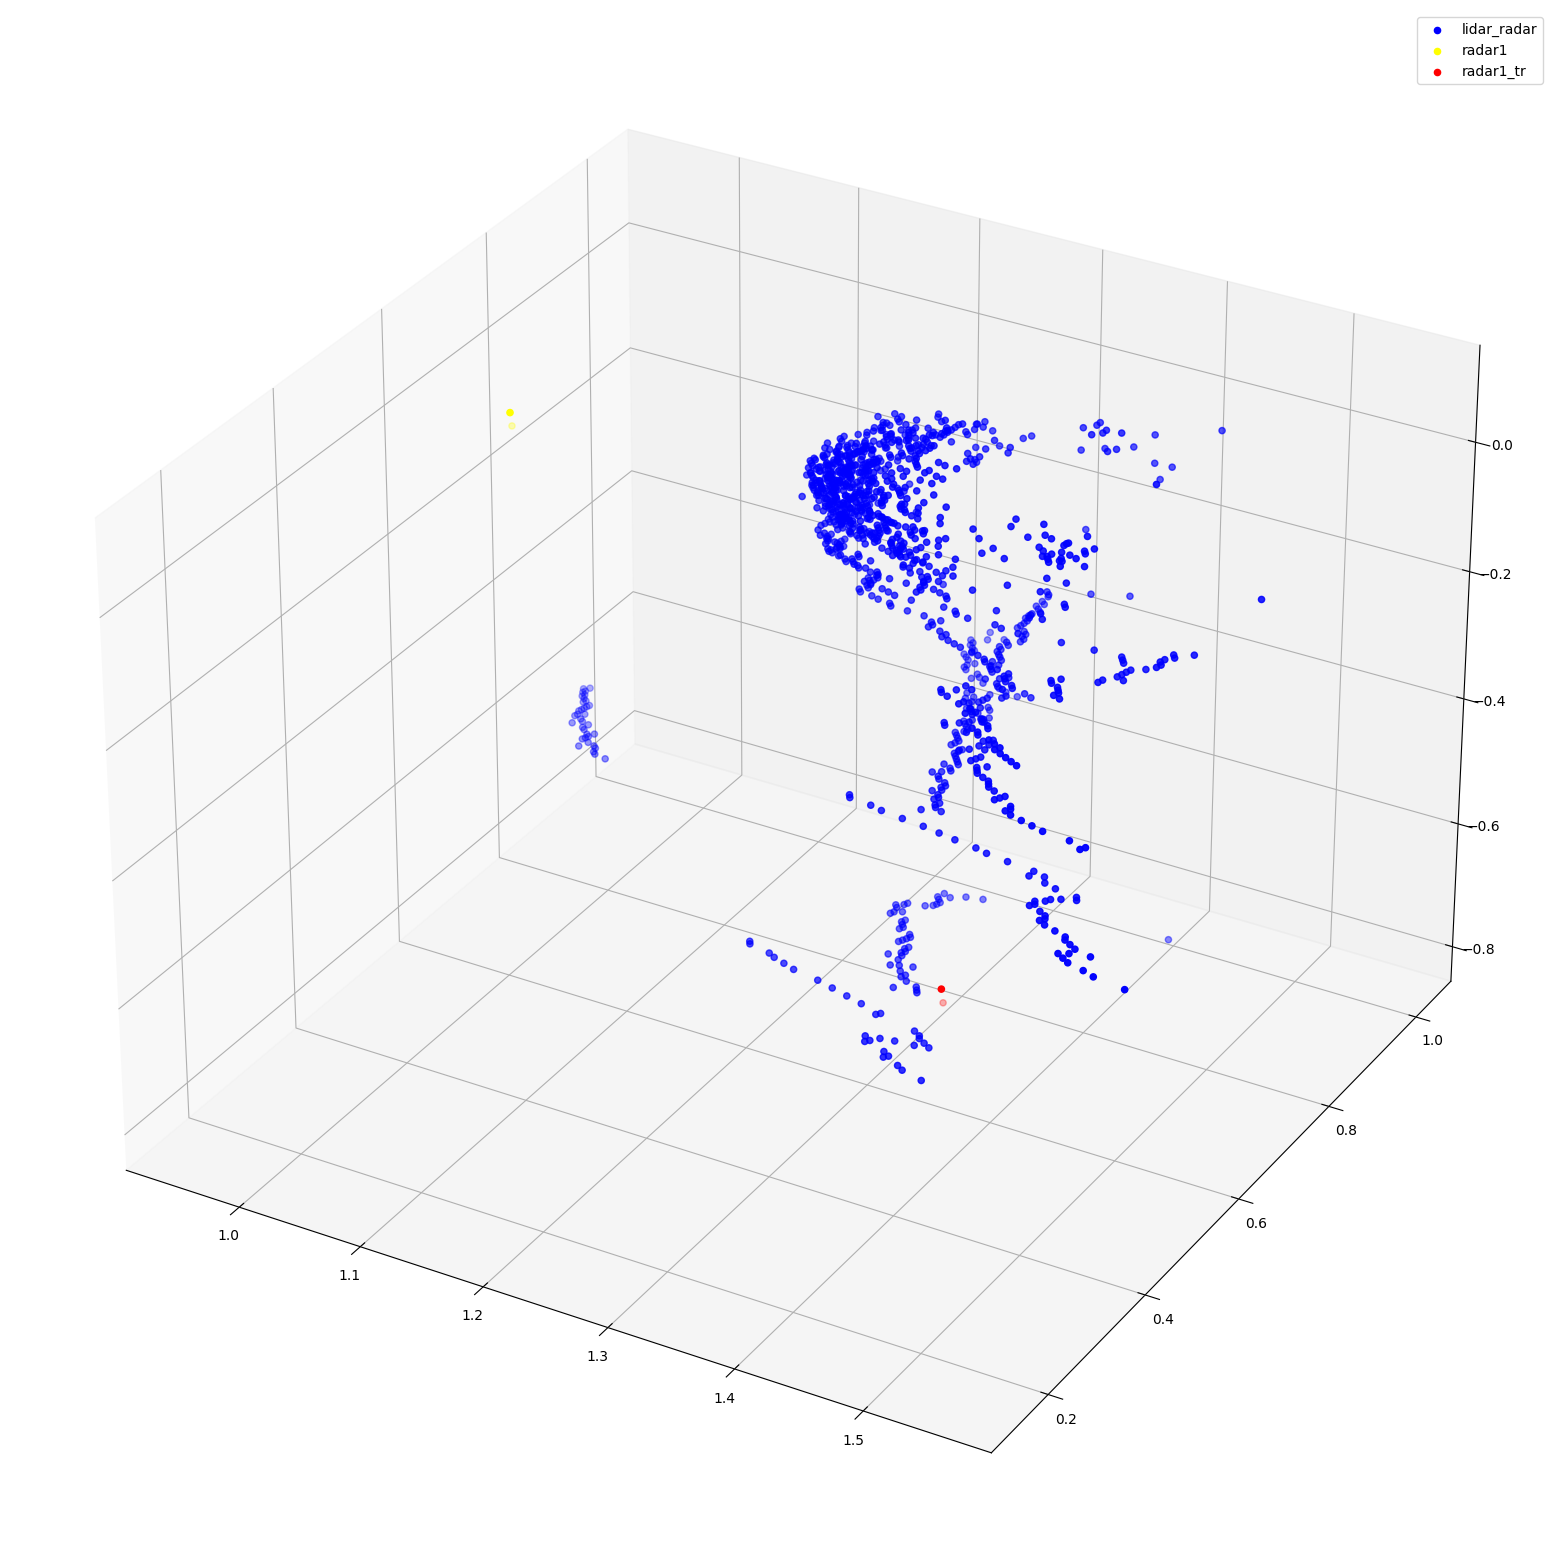

In [42]:
plot_lidar_radar(lidar_xyz=None,
                 lidar_radar_xyz=np_lr,
                 radar_xyz=np_r,
                 radar_xyz_tr=np_r_tr)

In [43]:
main_loop('/home/devel/finest_data/out1', 
          get_lidar_cam_radar_sync(df_sync_radar1_lidar, df_lidar_cam_sync),
          lidar_camera_calib, tr_radar_lidar)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [61]:
import utils as rlc_utils

In [59]:
from importlib import reload

In [67]:
reload(rlc_utils)

<module 'utils' from '/home/devel/workspaces/finest_mobility/src/data_unpack/src/utils.py'>

In [74]:
rlc_utils.RLCSyncSession(lidar_dir_path='.',
                         radar_dir_path='.',
                         camera_dir_path='.').__dict__()

{'lidar_dir_path': '.',
 'radar_dir_path': '.',
 'camera_dir_path': '.',
 'radar_nr': 'radar1'}

In [5]:
import pandas as pd
df_radar1_lidar_cam_sync =\
               pd.read_csv('/home/devel/Data/lidar_cam_calib_db_project/radar1-to-lidar-to-cam-seq-sync.csv')

In [47]:
df_radar1_lidar_cam_sync.set_index('radar1').loc[[]].values.reshape(-1)[1]

KeyError: 'None of [0] are in the columns'